# PE study 
Run PE with SGVB and welch

In [1]:
"""
Runs a parameter estimation study comparing SGVB and Welch PSD estimates.
"""
import bilby
import corner
from sgvb_univar.psd_estimator import PSDEstimator
import numpy as np
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey
import matplotlib.pyplot as plt

duration = 4.0
sampling_frequency = 1024.0
minimum_frequency = 20
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomPv2",
        reference_frequency=50.0,
        minimum_frequency=minimum_frequency,
    ),
)
# DONT ANALYSE THESE FOR NOW -- TO SPEED UP
fixed_analysis_params = [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]


def prepare_interferometers(det_names, sampling_frequency, duration, start_time):
    """Create an InterferometerList and set strain data from PSDs.

    Returns the InterferometerList.
    """
    ifos = bilby.gw.detector.InterferometerList(det_names)
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=start_time,
    )
    return ifos


def get_fd_data(strain_data: np.ndarray, times: np.ndarray, det: str, roll_off: float, fmin: float, fmax: float):
    """Fixed function with correct variable names and parameters."""
    if fmax is None:
        fmax = sampling_frequency//2
    
    strain_ts = TimeSeries(strain_data, times=times)
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    ifo.strain_data.roll_off = roll_off
    ifo.maximum_frequency = fmax  # Fixed: was f_f
    ifo.minimum_frequency = fmin  # Fixed: was f_i
    ifo.strain_data.set_from_gwpy_timeseries(strain_ts)

    x = ifo.strain_data.frequency_array
    y = ifo.strain_data.frequency_domain_strain
    Ew = np.sqrt(ifo.strain_data.window_factor)

    I = (x >= fmin) & (x <= fmax)  # Fixed: was f_i and f_f
    return x[I], y[I] / Ew


def estimate_welch_psd(
        ts: TimeSeries,
        sampling_frequency: float = 4096,
        duration = 4.0,
        psd_fractional_overlap: float = 0.5,
        post_trigger_duration: float = 2.0,
        psd_length: int = 32,
        psd_maximum_duration: int = 1024,
        psd_method: str = "median",
        psd_start_time: float | None = None,
        minimum_frequency: float | None = 20.0,
        maximum_frequency: float | None = None,
        tukey_roll_off: float = 0.4,
):
    """
    Estimate the PSD of a time series using Welch's method via gwpy.

    Parameters
    ----------
    ts : gwpy.timeseries.TimeSeries
        Input strain or time series data.
    sampling_frequency : float
        Sampling frequency in Hz (default: 4096).
    psd_fractional_overlap : float
        Fractional overlap of Welch segments (default: 0.5).
    post_trigger_duration : float
        Duration (s) of data after trigger (default: 2.0).
    psd_length : int
        Multiplier for segment duration (default: 32).
    psd_maximum_duration : int
        Maximum PSD segment duration (default: 1024 s).
    psd_method : str
        PSD estimator method ("mean", "median", etc.) (default: "median").
    psd_start_time : float or None
        Relative start time (seconds before main segment). If None,
        uses `psd_length * post_trigger_duration` before segment start.
    minimum_frequency : float or None
        Minimum frequency (Hz) to include (default: 20).
    maximum_frequency : float or None
        Maximum frequency (Hz) to include (default: None = Nyquist).
    tukey_roll_off : float
        Roll-off (s) for Tukey window (default: 0.4).

    Returns
    -------
    psd : gwpy.spectrum.Spectrum
        The estimated power spectral density.

    SEE https://git.ligo.org/lscsoft/bilby_pipe/-/blob/master/bilby_pipe/parser.py?ref_type=heads#L334
    and
    https://git.ligo.org/lscsoft/bilby_pipe/-/blob/master/bilby_pipe/data_generation.py?ref_type=heads#L572

    """
    #psd_duration = min(psd_length * duration, psd_maximum_duration)
    if maximum_frequency is None:
        maximum_frequency = sampling_frequency//2

    # Calculate the Tukey alpha parameter
    tukey_alpha = 2 * tukey_roll_off / duration
    overlap = psd_fractional_overlap * duration

    print(
        "Welch PSD settings: fftlength=%s, overlap=%s, method=%s, "
        "tukey_alpha=%s (roll-off=%s)",
        duration, overlap, psd_method, tukey_alpha, tukey_roll_off,
    )

    # Apply Welch PSD estimation
    psd = ts.psd(
        fftlength=duration,
        overlap=overlap,
        window=("tukey", tukey_alpha),
        method=psd_method,
    )

    # Restrict frequency band
    freqs_welch = psd.frequencies.value
    mask = (freqs_welch >= minimum_frequency) & (freqs_welch <= maximum_frequency)
    freqs_welch = freqs_welch[mask]
    psd = psd[mask]

    return freqs_welch, psd


def estimate_sgvb_psd(time_series, sampling_frequency, duration=4,
                      minimum_frequency = 20.0, maximum_frequency = None,
                      N_theta=800, nchunks=32, ntrain_map=10000,
                      N_samples=500, degree_fluctuate=8000, seed=None,
                      tukey_roll_off = 0.4):
    
    N = int(duration * sampling_frequency)        
    tukey_alpha = 2 * tukey_roll_off / duration
    w = tukey(N, tukey_alpha)
    Ew = np.sqrt(np.mean(w**2))
    
    if maximum_frequency is None:
        maximum_frequency = sampling_frequency//2
        
    frange = [minimum_frequency, maximum_frequency]    
    x = np.asarray(time_series).reshape(-1, 1)
    psd_est = PSDEstimator(
        x=x,
        N_theta=N_theta,
        nchunks=nchunks,
        ntrain_map=ntrain_map,
        N_samples=N_samples,
        fs=sampling_frequency,
        max_hyperparm_eval=1,
        degree_fluctuate=degree_fluctuate,
        n_elbo_maximisation_steps=600,
        frange=frange
    )
    psd_est.run(lr=0.02)
    freqs = psd_est.freq
    psd = psd_est.pointwise_ci[1]
    psd = psd*2 / Ew**2
    return freqs, psd


/home/avaj040/Documents/venvs/sgvb_univar/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-09 15:14:22.976696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 15:14:22.988976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-09 15:14:23.087633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-09 15:14:23.237624: E external/local_xla/xla/

>>>> Running PE study with seed = 0  <<<<


15:31 bilby INFO    : No prior given, using default BBH priors in /home/avaj040/Documents/venvs/sgvb_univar/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
15:31 bilby INFO    : No prior given, using default BBH priors in /home/avaj040/Documents/venvs/sgvb_univar/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


Injection parameters:
  mass_ratio: 0.4498144949229336
  chirp_mass: 56.1627139794391
  luminosity_distance: 1064.9292372112734
  dec: -1.3129630393971965
  ra: 5.109927617709579
  theta_jn: 2.5419036106280677
  psi: 1.9058024965549174
  phase: 4.583562073612696
  a_1: 0.5381887415507687
  a_2: 0.9257216995498906
  tilt_1: 2.2545496995135017
  tilt_2: 0.10470919008406826
  phi_12: 5.3872299529679575
  phi_jl: 0.21102439329246717
  geocent_time: 2.0

Analysis priors:
  mass_1: Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
  mass_2: Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None)
  mass_ratio: bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
  chirp_mass: bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
  luminosity_distance

15:31 bilby INFO    : Injected signal in H1:
15:31 bilby INFO    :   optimal SNR = 24.65
15:31 bilby INFO    :   matched filter SNR = 24.44-0.40j
15:31 bilby INFO    :   mass_ratio = 0.4498144949229336
15:31 bilby INFO    :   chirp_mass = 56.1627139794391
15:31 bilby INFO    :   luminosity_distance = 1064.9292372112734
15:31 bilby INFO    :   dec = -1.3129630393971965
15:31 bilby INFO    :   ra = 5.109927617709579
15:31 bilby INFO    :   theta_jn = 2.5419036106280677
15:31 bilby INFO    :   psi = 1.9058024965549174
15:31 bilby INFO    :   phase = 4.583562073612696
15:31 bilby INFO    :   a_1 = 0.5381887415507687
15:31 bilby INFO    :   a_2 = 0.9257216995498906
15:31 bilby INFO    :   tilt_1 = 2.2545496995135017
15:31 bilby INFO    :   tilt_2 = 0.10470919008406826
15:31 bilby INFO    :   phi_12 = 5.3872299529679575
15:31 bilby INFO    :   phi_jl = 0.21102439329246717
15:31 bilby INFO    :   geocent_time = 2.0


Welch PSD settings: fftlength=%s, overlap=%s, method=%s, tukey_alpha=%s (roll-off=%s) 4.0 2.0 median 0.2 0.4
Step 5000 : log posterior [-23744.0977]
Step 10000 : log posterior [-24592.3164]


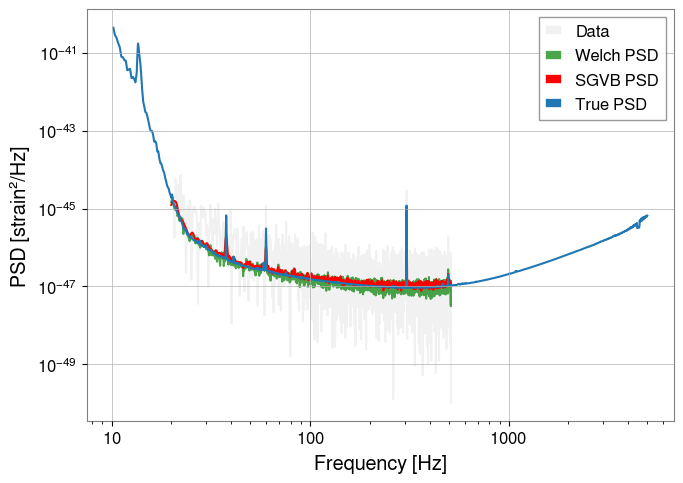

In [29]:
seed = 0
bilby.core.utils.random.seed(seed)
label = f"seed_{seed}"
outdir = "outdir_pe_study"
det_names = ["H1"]

print(">>>> Running PE study with seed =", seed, " <<<<")
## SETUP INJECTION + PRIORS FOR ANALYSIS

inj_prior = bilby.gw.prior.BBHPriorDict()
injection_params = inj_prior.sample()
injection_params['geocent_time'] = 2.0
# delta functions for all params not in params_to_sample
analysis_prior = bilby.gw.prior.BBHPriorDict()
for key in fixed_analysis_params:
    # Assign a delta-prior by setting the prior to the injected value
    analysis_prior[key] = injection_params[key]
analysis_prior.validate_prior(duration, minimum_frequency)

# print out the injection parameters, and analysis priors
print("Injection parameters:")
for k, v in injection_params.items():
    print(f"  {k}: {v}")
print("\nAnalysis priors:")
for k, v in analysis_prior.items():
    print(f"  {k}: {v}")

# Setup logger and seed specifically for this run
bilby.core.utils.setup_logger(outdir=outdir, label=label)
bilby.core.utils.random.seed(seed)

start_time = injection_params["geocent_time"] - 2
signal_end_time = start_time + duration
psd_start_time = start_time + duration
psd_end_time = psd_start_time + duration * 32
ifos = prepare_interferometers(det_names, sampling_frequency, duration=duration, start_time=start_time)
ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_params)

noise_ifos = prepare_interferometers(det_names, sampling_frequency,
                                     duration=duration * 32, start_time=psd_start_time)

psd_estimates = {}

# Extract noise-only segment (all data after injection )
for ifo in ifos:
    on_source_data = np.asarray(ifo.strain_data.time_domain_strain)#.time_slice(start_time, signal_end_time)
    psd_data = TimeSeries(np.asarray(noise_ifos[0].strain_data.time_domain_strain), 
                          dt = 1.0/sampling_frequency)#.time_slice(signal_end_time, psd_end_time)

    # Compute Welch PSD + SGVB PSD
    freqs_welch, welch_psd = estimate_welch_psd(psd_data, sampling_frequency)
    freqs_sgvb, sgvb_psd = estimate_sgvb_psd(psd_data, sampling_frequency)

    # TODO: plot the two PSDs for comparison along with on-source data

    psd_estimates['welch'] = (freqs_welch, welch_psd)
    psd_estimates['sgvb'] = (freqs_sgvb, sgvb_psd)
    
    
# plot the two PSDs for comparison along with on-source data
freqs_welch, welch_psd = psd_estimates['welch']
freqs_sgvb,  sgvb_psd  = psd_estimates['sgvb']

N = len(on_source_data)                   
times = np.arange(N) / sampling_frequency         
f, on_source_f = get_fd_data(on_source_data, times = times, det='H1',
                          roll_off = 0.4, fmin = minimum_frequency, fmax = None)

fig = plt.figure(figsize=(7, 5))
plt.loglog(f, np.abs(on_source_f)**2, alpha=0.3, label="Data", color = "lightgray")
plt.loglog(freqs_welch, welch_psd, alpha=0.7, label="Welch PSD", color = "green")
plt.loglog(freqs_sgvb, sgvb_psd[:,0,0], alpha=1, label="SGVB PSD", color = "red")
plt.loglog(ifos[0].power_spectral_density.frequency_array,
           ifos[0].power_spectral_density.psd_array,
           label='True PSD') 
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [strain²/Hz]")
plt.legend()
plt.tight_layout()
plt.show()
outpath = f"{outdir}/SGVB_Welch_PSDs.png"
fig.savefig(outpath, dpi=200)



In [23]:
from bilby.gw.detector.psd import PowerSpectralDensity


psds = dict(
    welch=PowerSpectralDensity.from_amplitude_spectral_density_array(
    freqs_welch, np.sqrt(welch_psd)
),
    sgvb=PowerSpectralDensity.from_amplitude_spectral_density_array(
    freqs_sgvb, np.sqrt(sgvb_psd)[:,0,0]
),
)


In [31]:


import copy

ifos_orig = copy.deepcopy(ifos)
ifos_welch = copy.deepcopy(ifos)
ifos_sgvb = copy.deepcopy(ifos)

welch_psd_object = PowerSpectralDensity.from_amplitude_spectral_density_array(
    freqs_welch, np.sqrt(welch_psd)
)
sgvb_psd_object = PowerSpectralDensity.from_amplitude_spectral_density_array(
    freqs_sgvb, np.sqrt(sgvb_psd)[:,0,0]
)

for i in range(len(ifos_orig)):
    ifos_welch[i].power_spectral_density = welch_psd_object
    ifos_sgvb[i].power_spectral_density = sgvb_psd_object

ifos_for_analysis = dict(
    welch=ifos_welch,
    sgvb=ifos_sgvb,
    original=ifos_orig,
)


In [ ]:


# Now we do the analysis twice, once with each PSD
results = {}
for name, analysis_ifos in ifos_for_analysis.items():
    likelihood = bilby.gw.GravitationalWaveTransient(interferometers=analysis_ifos, waveform_generator=waveform_generator)
    print("Running analysis with", name, "PSD")
    print(likelihood.interferometers[0].power_spectral_density)
    run_label = f"{label}_{name}"
    res = bilby.run_sampler(
        likelihood=likelihood,
        priors=analysis_prior,
        sampler="dynesty",
        npoints=10,
        injection_parameters=injection_params,
        outdir=outdir,
        label=run_label,
        resume=False,
    )
    results[name] = res

# compute Bayes factor SGVB vs Welch
logZ_welch = results["welch"].log_evidence
logZ_sgvb = results["sgvb"].log_evidence
logBF = logZ_sgvb - logZ_welch
BF = np.exp(logBF)

print(f"logZ (welch) = {logZ_welch:.3f}")
print(f"logZ (sgvb)  = {logZ_sgvb:.3f}")
print(f"logBF (sgvb - welch) = {logBF:.3f}, BF = {BF:.3e}")

# Produce an overlaid corner plot of the sampled posteriors
post_w = results["welch"].posterior
post_s = results["sgvb"].posterior
param_names = [c for c in post_w.columns if c not in ["log_likelihood", "weight"]]

samples_w = post_w[param_names].to_numpy()
samples_s = post_s[param_names].to_numpy()

fig = corner.corner(samples_w, labels=param_names, color='C0', show_titles=True,
                    title_fmt='.2f', plot_datapoints=False)
corner.corner(samples_s, labels=param_names, fig=fig, color='C1', plot_datapoints=False,
              plot_contours=True, fill_contours=False)
fig.suptitle(f"Overlaid posteriors: SGVB (C1) vs Welch (C0)\nlogBF={logBF:.2f}")
outpath = f"{outdir}/{label}_overlaid_corner.png"
fig.savefig(outpath, dpi=200)
print(f"Saved overlaid corner to {outpath}")

# Make a corner plot for the last result as in the original example.
results['sgvb'].plot_corner()

meta = dict(
    welch_freq=freqs_welch,
    welch_psd=welch_psd,
    sgvb_freq=freqs_sgvb,
    sgvb_median=sgvb_psd,
)

Running analysis with welch PSD
PowerSpectralDensity(frequency_array=[ 20.    20.25  20.5  ... 511.5  511.75 512.  ], psd_array=[1.48090448e-45 1.99887972e-45 1.26724807e-45 ... 1.38678719e-47
 1.06904041e-47 3.20611360e-48] 1 / Hz, asd_array=[3.84825218e-23 4.47088326e-23 3.55984279e-23 ... 3.72395917e-24
 3.26961834e-24 1.79056237e-24])


15:33 bilby INFO    : Running for label 'seed_0_welch', output will be saved to 'outdir_pe_study'
15:33 bilby INFO    : Using lal version 7.7.0
15:33 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
15:33 bilby INFO    : Using lalsimulation version 6.2.0
15:33 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
15:33 bilby INFO    : Analysis priors:
15:33 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
15:33 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=No

54it [00:20,  1.79it/s, bound:10 nc:775 ncall:6.4e+03 eff:0.8% logz-ratio=232.44+/-0.79 dlogz:50.7>0.1]